# Intro: modelo de Yard-Sale

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

Lo primero que necesitamos es una clase que guarde el modelo base.

In [7]:
class model:
    def __init__(self, n_agents, w_min=3*1e-15, every=1):
        # Basic params of model
        self.N = n_agents
        self.w_min = w_min
        self.every = every
        # Initialize n agents with random risks and wealth between (0, 1] 
        # and normalize wealth
        # n[i, 0] is the wealth and n[i, 1] is the risk of agent i
        self.n = np.random.rand(self.N, 2)
        # Normalize wealth
        self.n[:, 0] = self.n[:, 0]/(np.sum(self.n[:, 0]))
        self.gini = []
        # Compute initial Gini
        self.gini.append(self.get_gini())
        # Compute initial active agents
        self.n_active = [self.get_actives()]

    def get_opponents(self):
        """Snippet that assigns each agent with another random agent for a 
        pairwise interaction fast and returns an array of opponents
        """
        # Create array of random numbers
        random_array = np.random.randint(0, self.N, self.N)
        # Create array of indices
        indices = np.arange(0, self.N)
        # Create array of random numbers that are not equal to the index
        # If i=j then assign j'=i+1 (j'=0 if i=N-1)
        random_array = np.where(random_array == indices, 
                                (random_array + 1) % self.N, 
                                random_array)
        return random_array
    
    def is_valid(self, i, j):
        # Check if both agents have w > w_min
        valid = (self.n[i, 0] > self.w_min) and (self.n[j, 0] > self.w_min)
        # Setting w_i < w_min to w_i = 0 only introduces error in W_tot ~ 1
        # Maybe there is no need to do this
            # # Set agents with less than w_min to zero
            # self.n[i, 0] = np.where(self.n[i, 0] < self.w_min, 0, self.n[i, 0])
            # self.n[j, 0] = np.where(self.n[j, 0] < self.w_min, 0, self.n[j, 0])
        return valid

    def get_dw(self, i, j):
        return np.minimum(self.n[i,0]*self.n[i,1], self.n[j,0]*self.n[j,1])

    def get_gini(self):
        w = np.sort(self.n[:, 0])
        p_cumsum = np.cumsum(w) / np.sum(w)
        B = np.sum(p_cumsum) / self.N
        return 1 + 1/self.N - 2*B
    
    def get_actives(self):
        return np.sum(self.n[:,0]>self.w_min)
    
    def get_liquidity():
        return

    def update_wealth(self, i, j, dw):
        self.n[i, 0] += dw
        self.n[j, 0] -= dw

    def choose_winner(self, i, j):
        raise Exception('You need to choose a valid model.')

    def MCS(self, steps):
        """
        Main MC loop
        """

        for mcs in range(steps):
            # Choose random j!=i
            j = self.get_opponents()
            
            for i in range(self.N):
                # Check both agents have w > w_min
                if self.is_valid(i, j[i]):
                    # Compute dw
                    dw = self.get_dw(i, j[i])
                    # Play the YS game
                    winner = self.choose_winner(i, j[i])
                    # Change sign of dw if j won
                    dw = np.where(winner == i, dw, -dw)
                    # Update_wealth
                    self.update_wealth(i, j[i], dw)
                
            # After self.every MCS append new Gini index
            if ((mcs + 1) % self.every == 0):
                self.gini.append(self.get_gini())
                self.n_active.append(self.get_actives())



Ahora definimos el modelo de Yard-Sale, que hereda del modelo base.

In [8]:
class YSmodel(model):
    def __init__(self, n_agents, w_min=3*1e-15, f=0, every=1):
        super().__init__(n_agents, w_min, every)
        # f is the social protection factor
        self.f = f

    def choose_winner(self, i, j):
        p = .5 + self.f*((self.n[j,0] - self.n[i,0])/
                         (self.n[i,0] + self.n[j,0]))
        # Choose winner, agent i has probability i
        winner = np.random.choice([i, j], p=[p, 1-p])
        return winner

In [4]:
model = YSmodel(1000, w_min=1e-14, f=.1, every=1)
model.f

0.1

In [66]:
model.MCS(10000)

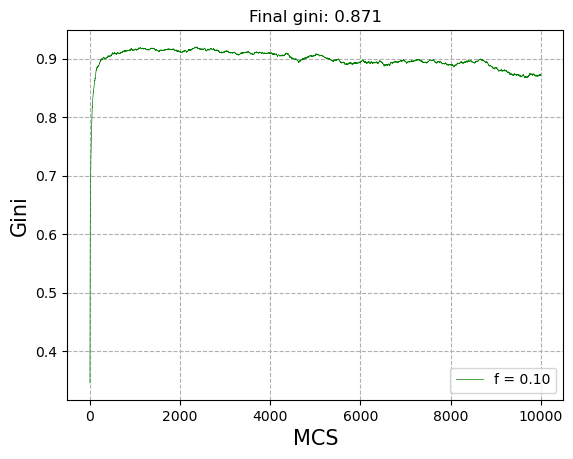

In [67]:
fig, ax = plt.subplots()

ax.plot(model.gini, label='f = {:.2f}'.format(model.f), color='green', linewidth=.5)
ax.set_xlabel('MCS', size=15)
ax.set_ylabel('Gini', size=15)
#ax.set_xticks(np.arange(0, 100000, 10000), minor=True)
#ax.set_yticks(np.arange(.35, 1.05, .05), minor=True)
ax.legend(loc='lower right')
ax.set_title("Final gini: {:.3f}".format(model.gini[-1]))
ax.grid(which='minor', alpha=.5, linestyle='--')
ax.grid(which='major', alpha=1, linestyle='--')

plt.show()

In [5]:
n_act = model.get_actives()
w_richest = np.max(model.n[:,0])

print("No. of active agents: {}\nWealth of richest agent: {:.3f}".format(n_act, w_richest))

No. of active agents: 1000
Wealth of richest agent: 0.002


Ahora voy a recolectar datos para distintos f y así reproducir resultados de
juli/santi

In [11]:
filepath = os.path.join(os.getcwd(), "data/1_basic_results")

f_set = [0, .05, .1, .2, .3, .4, .5]
MCS = int(1e+5)

for f in f_set:
    model = YSmodel(1000, w_min=3*1e-17, f=f, every=1)
    model.MCS(MCS)
    
    path_gini = os.path.join(filepath, 'f={:.2f}_gini'.format(f))
    np.save(path_gini, np.array(model.gini))
    
    path_agents = os.path.join(filepath, 'f={:.2f}_agents'.format(f))
    np.save(path_agents, model.n[:, 0])

    path_active = os.path.join(filepath, 'f={:.2f}_active'.format(f))
    np.save(path_active, np.array(model.n_active))


In [45]:
# How to load file
path = os.path.join(filepath, 'f={:.2f}_agents.npy'.format(.1))

a = np.load(path)
